In [199]:
import simple_ebm
from simple_ebm import NeuralNet, sample_langevin, ReplayBuffer
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from data import sample_2d_data
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
# model = NeuralNet().cuda()
model = NeuralNet()
# data = np.random.multivariate_normal([0, 0], [[1, 5], [5, 10]], size=1000)
data = sample_2d_data('2spirals', 4096)
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data),
                                         batch_size=128, shuffle=True, num_workers=12)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0, betas=(0.0, 0.999))

replay_buffer = ReplayBuffer(8192, np.random.randn(*data.shape))

num_epochs = 100
reg_amount = 1
replay_frac = 0.95

# ----------- for plotting ----------- #
mesh = np.meshgrid(np.linspace(-4, 4, 200), np.linspace(-4, 4, 200))
coords = np.concatenate((mesh[0].reshape(-1, 1), mesh[1].reshape(-1, 1)), axis=1)
grid_num = torch.Tensor(coords)
grid_num.requires_grad = True

evaluated_list = []

for epoch in range(num_epochs):
    total_loss = []
    # total_poss_energy = []
    for pos_x, in dataloader:
        # pos_x = torch.Tensor(pos_x).cuda()
        pos_x = torch.Tensor(pos_x)
        # pos_x.requires_grad = True
        batch_size = pos_x.shape[0]

        neg_x = replay_buffer.sample(int(batch_size * replay_frac))
        neg_x_rand = np.random.randn(batch_size - neg_x.shape[0], *list(pos_x.shape[1:]))
        neg_x = np.concatenate([neg_x, neg_x_rand], axis=0)
        # neg_x = torch.Tensor(neg_x).cuda()
        neg_x = torch.Tensor(neg_x)
        neg_x.requires_grad = True

        sample_steps = 10
        step_size = 0.1
        noise_scale = 0.11
        neg_x = sample_langevin(neg_x, model, sample_steps=sample_steps, step_size=step_size, noise_scale=noise_scale)
        replay_buffer.add(neg_x)

        optimizer.zero_grad()

        pos_energy = model(pos_x)
        # neg_energy = model(neg_x.cuda())
        neg_energy = model(neg_x)
        energy_regularization = reg_amount * (pos_energy.square() +
                                              neg_energy.square())
        loss = (pos_energy - neg_energy + energy_regularization).mean()
        loss.backward()

        torch.nn.utils.clip_grad_norm(loss, 0.01)
        total_loss.append(loss.item())
        # print("Batch loss: {}".format(loss))

        optimizer.step()

    print("Epoch: {}\t Loss: {}".format(epoch, np.mean(total_loss)))
    evaluated_list.append(model(grid_num).detach().numpy().reshape(200, 200))

/home/phil/anaconda3/envs/ebm/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/phil/anaconda3/envs/ebm/lib/python3.7/site-packages/torch/nn/utils/clip_grad.py:27: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  parameters = [p for p in parameters if p.grad is not None]


Epoch: 0	 Loss: -0.04676862195628928
Epoch: 1	 Loss: -0.0414665003772825
Epoch: 2	 Loss: -0.02259866973327007
Epoch: 3	 Loss: -0.015885877877735766
Epoch: 4	 Loss: -0.01340398185129743
Epoch: 5	 Loss: -0.007491252650652314
Epoch: 6	 Loss: -0.00885927344643278
Epoch: 7	 Loss: -0.006227263544133166
Epoch: 8	 Loss: -0.006042192315362627
Epoch: 9	 Loss: -0.005919528764934512
Epoch: 10	 Loss: -0.005462300236104056
Epoch: 11	 Loss: -0.0035065598494838923
Epoch: 12	 Loss: -0.0067753551847999915
Epoch: 13	 Loss: -0.009886197633022675
Epoch: 14	 Loss: -0.010302813883754425
Epoch: 15	 Loss: -0.012205200673633954
Epoch: 16	 Loss: -0.011354538190062158
Epoch: 17	 Loss: -0.013563028296630364
Epoch: 18	 Loss: -0.013301750055688899
Epoch: 19	 Loss: -0.015129512128623901
Epoch: 20	 Loss: -0.01594212302734377
Epoch: 21	 Loss: -0.01583535761164967
Epoch: 22	 Loss: -0.01559712300877436
Epoch: 23	 Loss: -0.01770248622415238
Epoch: 24	 Loss: -0.017925469335750677
Epoch: 25	 Loss: -0.02233225217787549
Epoch

<IPython.core.display.Javascript object>


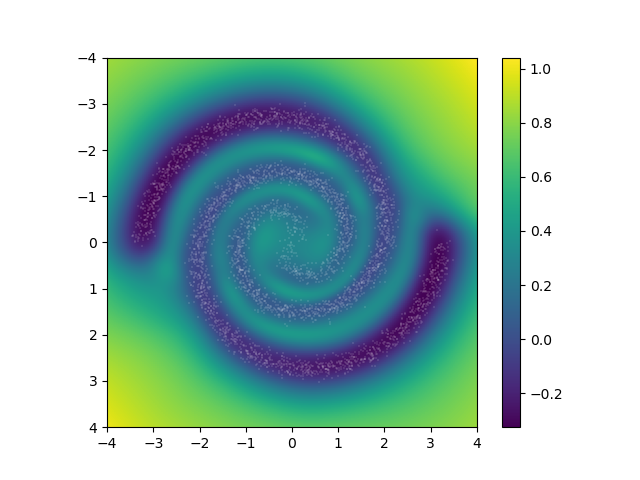

In [162]:
mesh = np.meshgrid(np.linspace(-4, 4, 200), np.linspace(-4, 4, 200))
coords = np.concatenate((mesh[0].reshape(-1, 1), mesh[1].reshape(-1, 1)), axis=1)
grid_num = torch.Tensor(coords)
grid_num.requires_grad = True

plt.figure()
# plt.imshow(model(grid_num).detach().numpy().reshape(200, 200), extent=(-4, 4, -4, 4))
plt.imshow(evaluated_list[-1], extent=(-4, 4, 4, -4))
plt.colorbar()

plt.scatter(data[:, 0], data[:, 1], marker='+', s=1, color=(1, 1, 1, 0.1))

# plt.scatter(samples[:, 0], samples[:, 1], marker='x', s=0.2)
# plt.contour(mesh[0], mesh[1], model(samples).detach().numpy().reshape(200, 200))

<IPython.core.display.Javascript object>


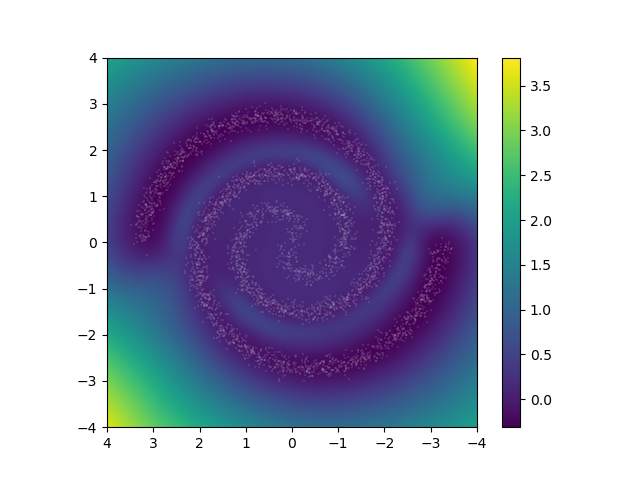

In [164]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(evaluated_list[0], extent=(4, -4, -4, 4))
cb = fig.colorbar(im, ax=ax)
plt.scatter(data[:, 0], data[:, 1], marker='+', s=1, color=(1, 1, 1, 0.1))

def animate(i):
    vmax = np.max(evaluated_list[i])
    vmin = np.min(evaluated_list[i])
    im.set_array(evaluated_list[i])
    im.set_clim(vmin, vmax)
    return im

anim = ani.FuncAnimation(fig, animate, frames=100, interval=40, blit=False)
anim.save('training_spiral3.mp4')

<IPython.core.display.Javascript object>


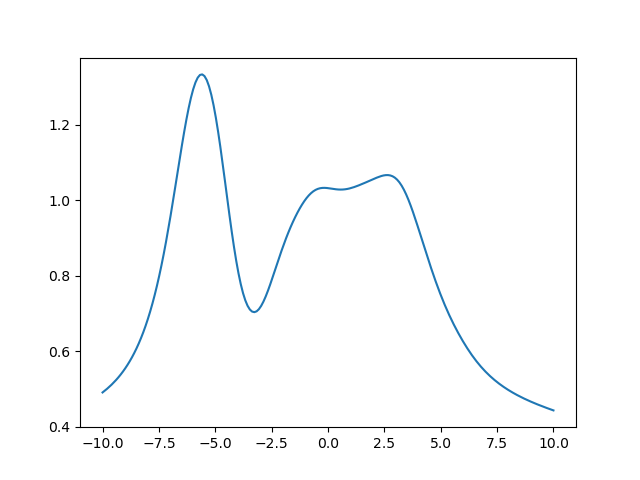

In [173]:
plt.figure()
plt.plot(np.linspace(-10, 10, 200), np.exp(-model(grid_num).detach().numpy().reshape(200, 200)[:, 50]))

<IPython.core.display.Javascript object>


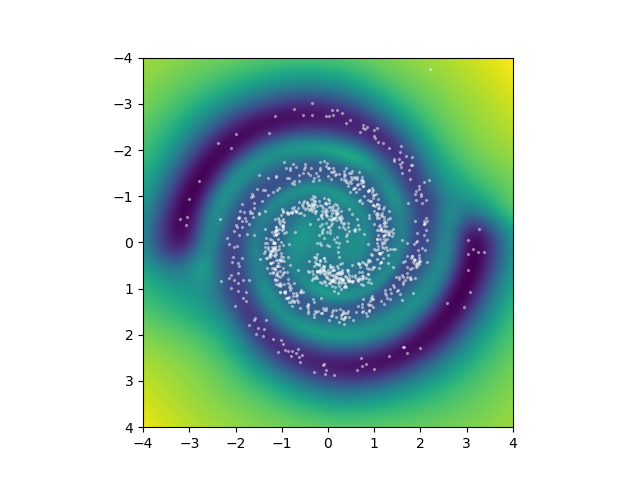

In [280]:
rand_num = torch.randn((1000, 2), requires_grad=True)
samples = sample_langevin(rand_num, model, step_size=0.1, sample_steps=50, noise_scale=0.1, return_list=True)
# plt.figure()
# plt.scatter(samples[:, 0], samples[:, 1], marker='x', s=2, color=(1, 1, 1, 0.3))



fig = plt.figure()
ax = plt.axes()
ax.imshow(evaluated_list[-1], extent=(-4, 4, 4, -4))
# scat = ax.scatter(samples[0][:, 0], samples[0][:, 1], marker='x', s=2, color=(0, 0, 0, 0.5))
scat = ax.scatter([], [],  marker='x', s=2, color=(1, 1, 1, 0.5))
# cb = fig.colorbar(im, ax=ax)

def animate(i):
    scat.set_offsets(np.hstack((samples[i][:, 0, np.newaxis], samples[i][:, 1, np.newaxis])))
    return scat,

anim = ani.FuncAnimation(fig, animate, frames=len(samples), interval=50, blit=False)
anim.save('sampling_spiral3.mp4')